Model for SO2TONS at LAKE-1:
  RMSE: 0.0000
  R²: 0.4835


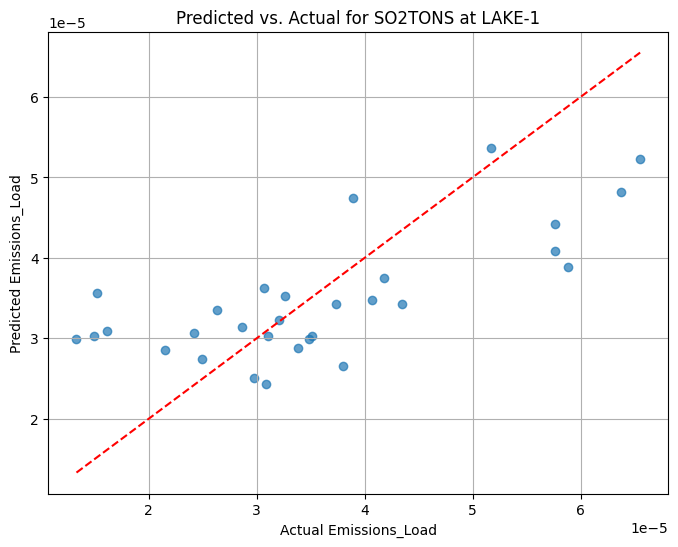

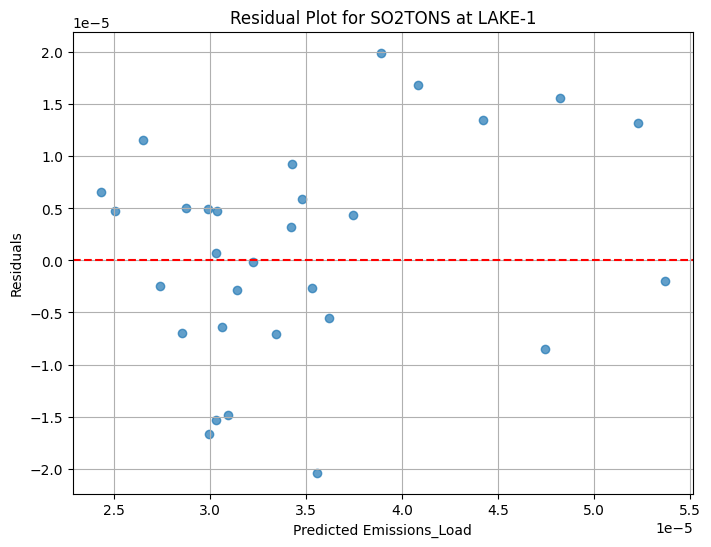

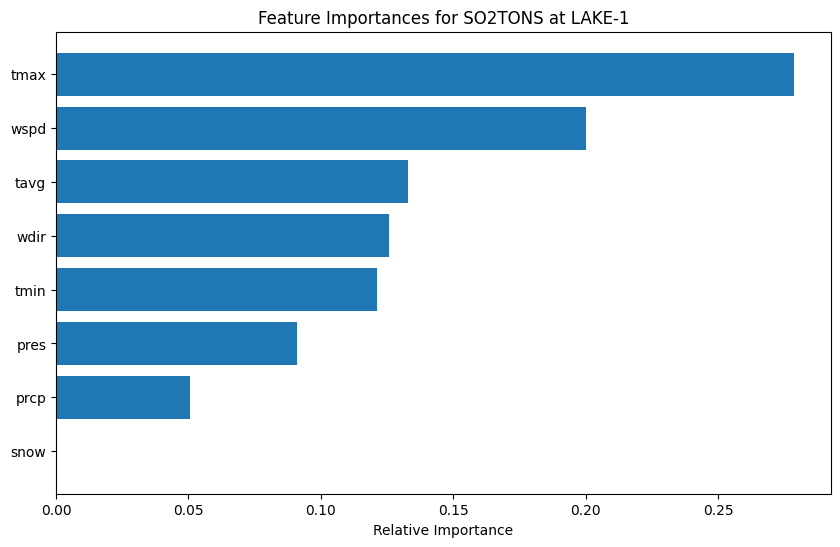

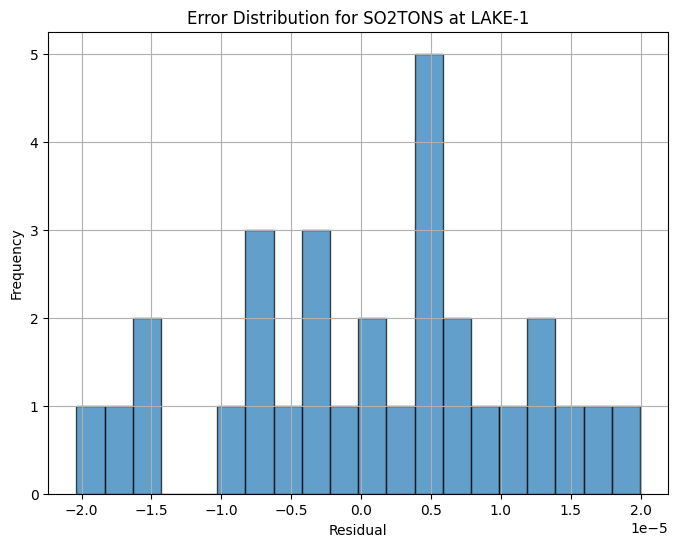

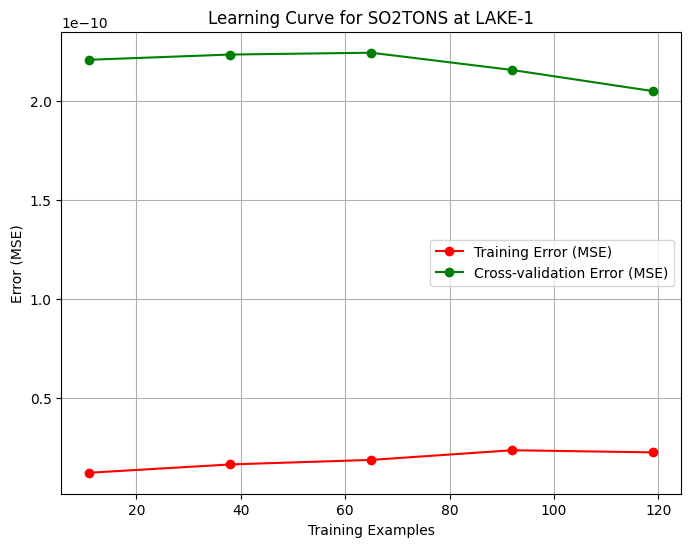

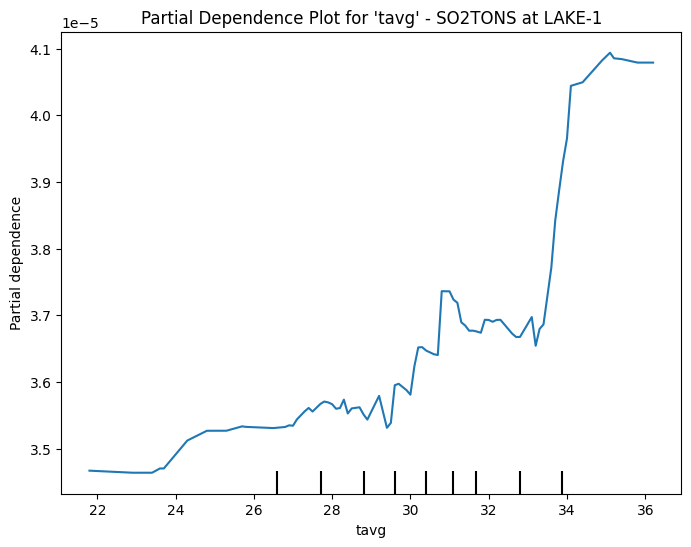

Model for SO2TONS at LAKE-2:
  RMSE: 0.0000
  R²: -0.0462


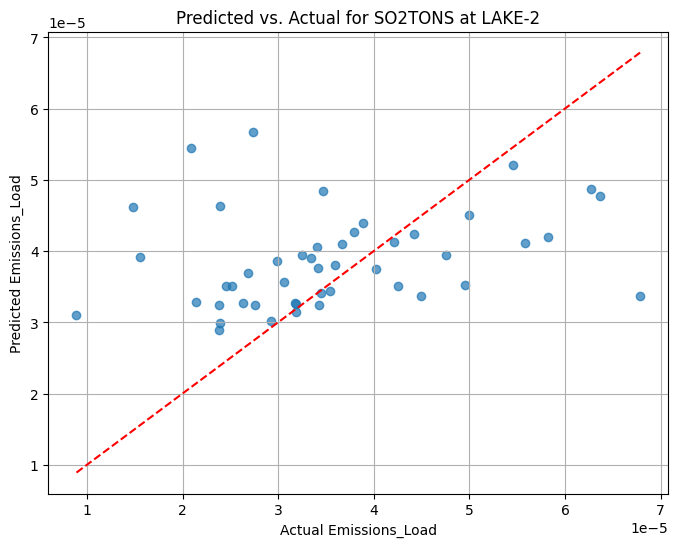

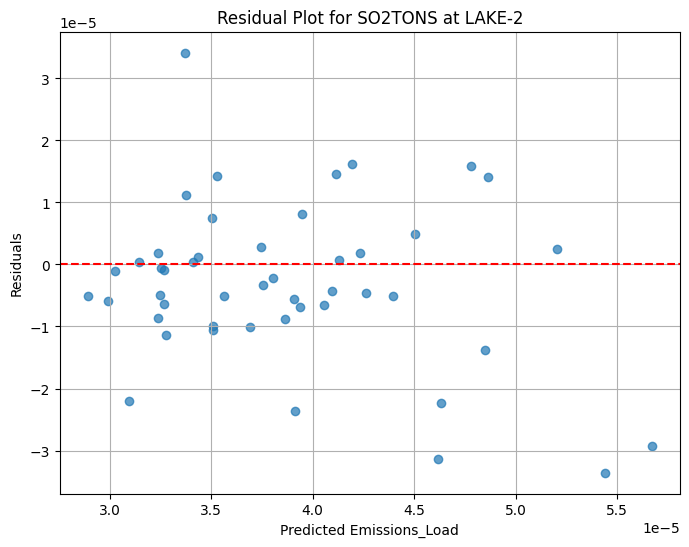

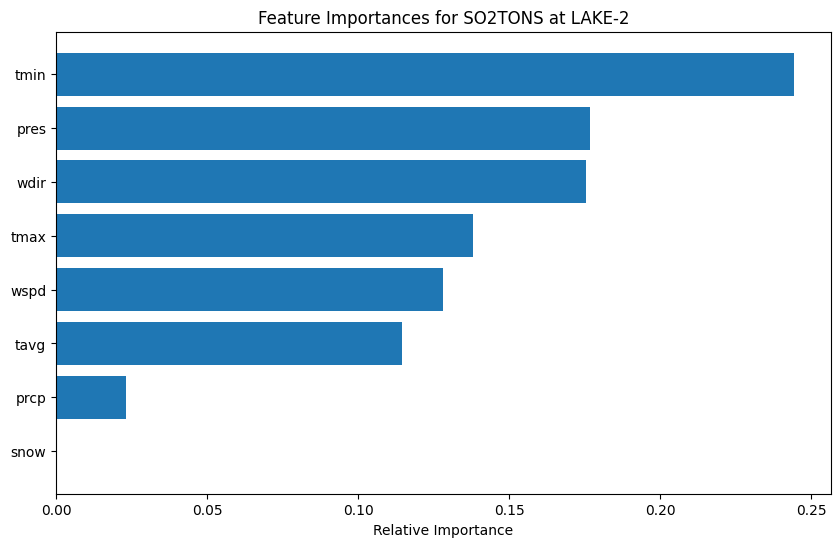

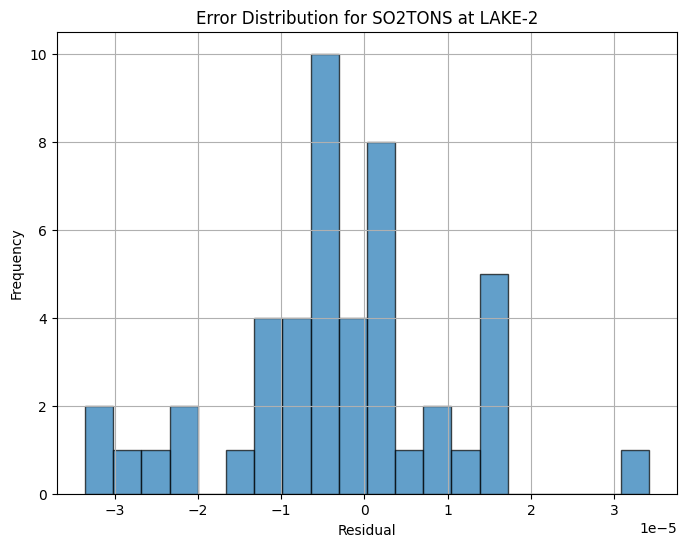

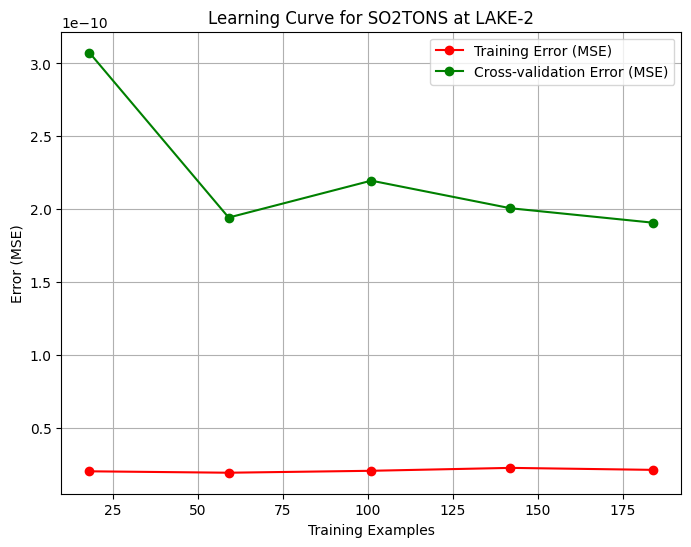

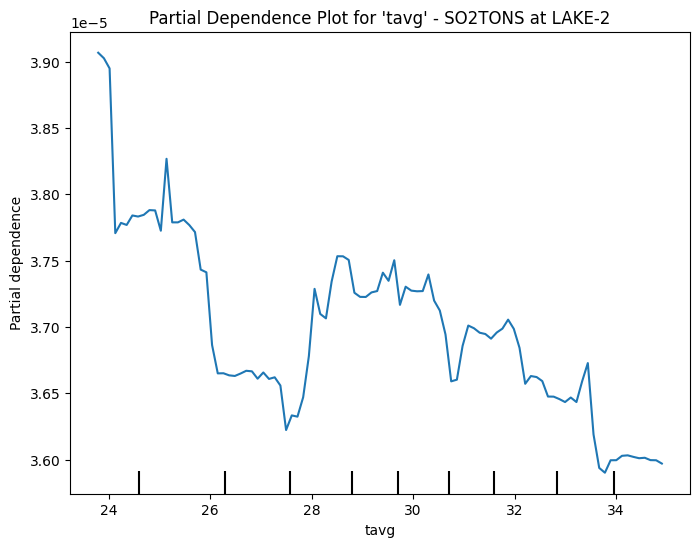

Model for SO2TONS at LAKE-3:
  RMSE: 0.0000
  R²: 0.3461


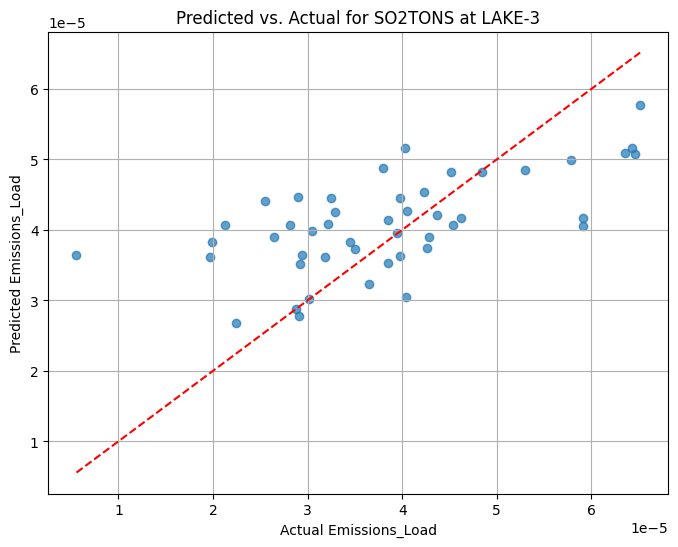

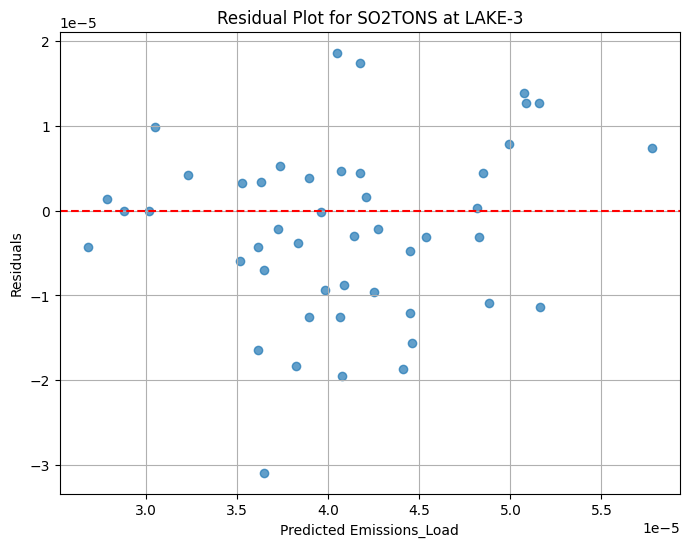

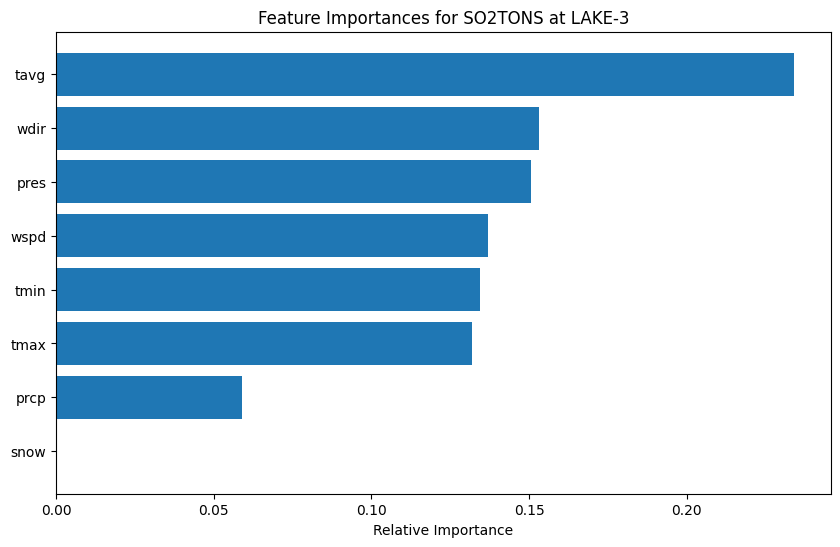

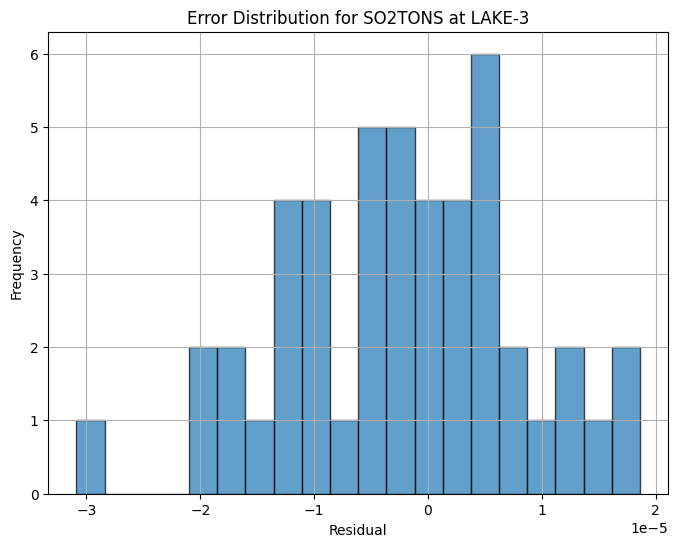

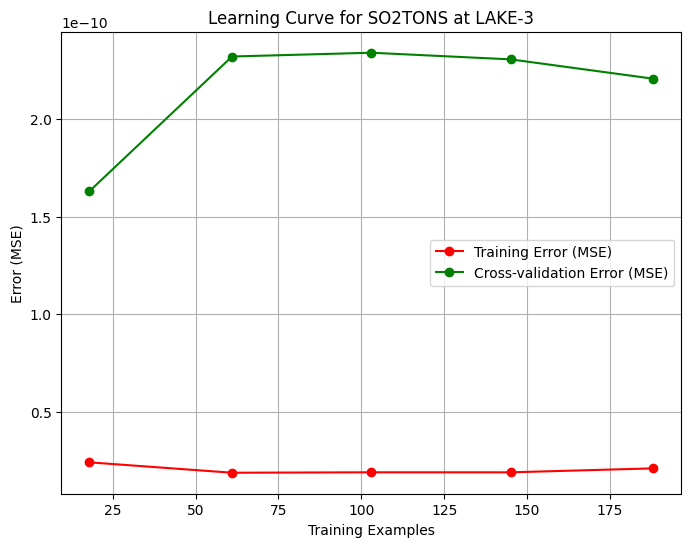

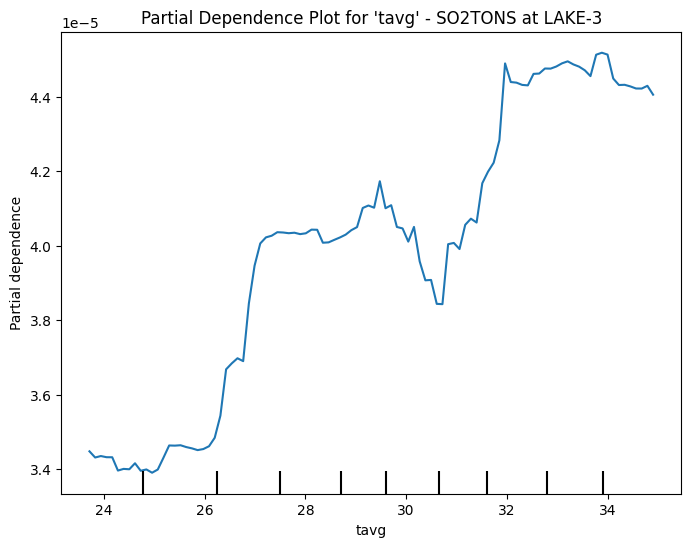

Model for SO2TONS at LAKE-4:
  RMSE: 0.0000
  R²: 0.2812


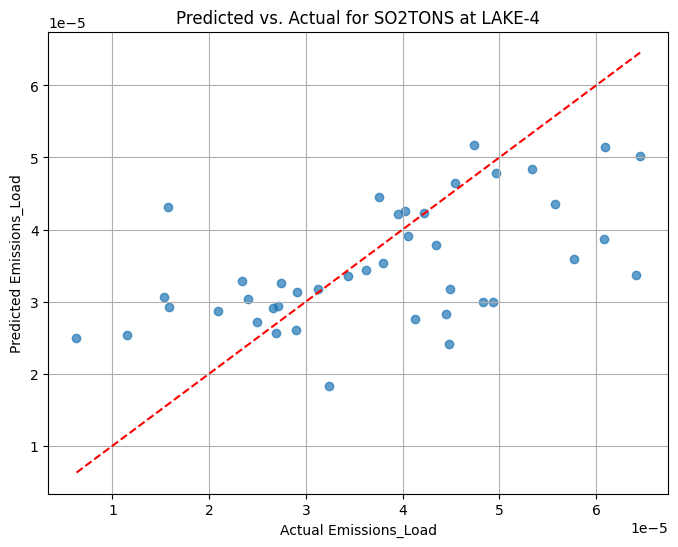

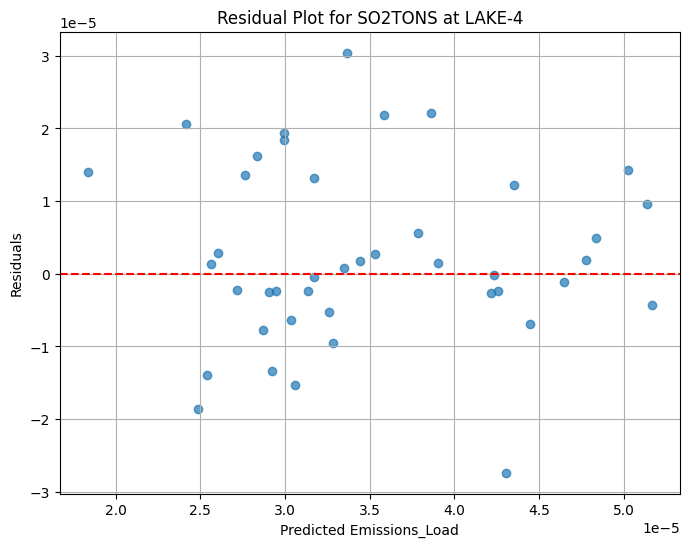

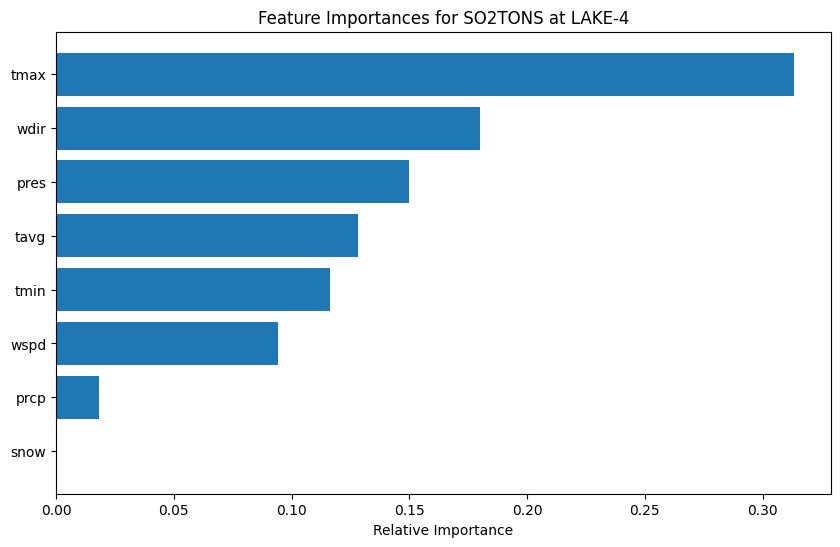

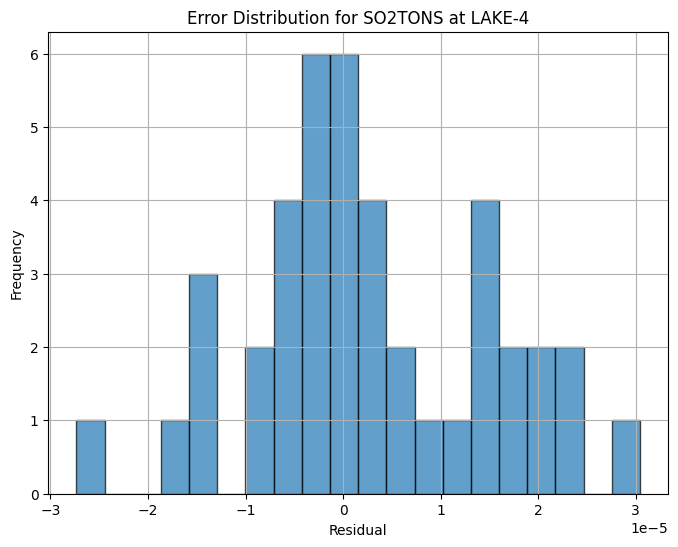

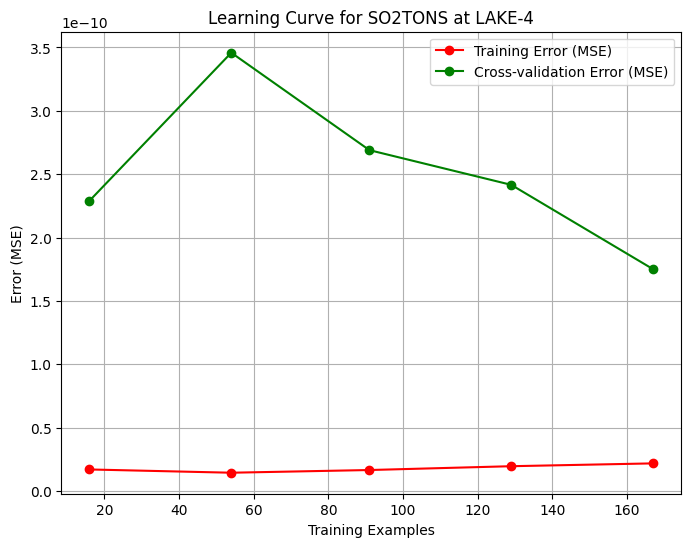

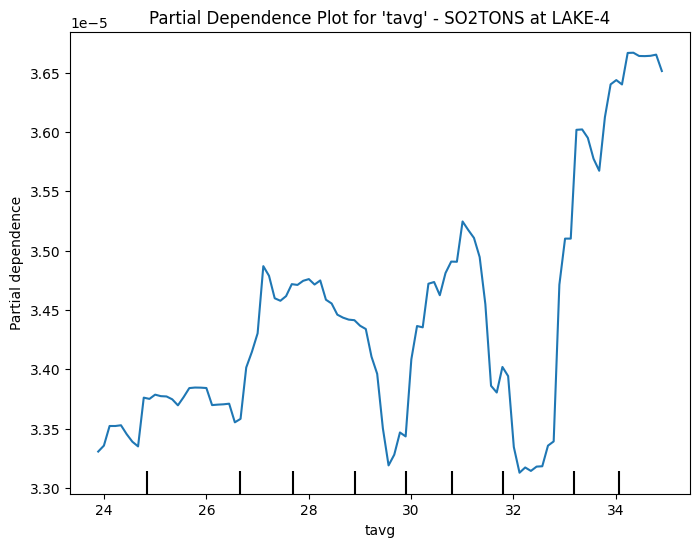

Model for NOXTONS at LAKE-1:
  RMSE: 0.0002
  R²: 0.2007


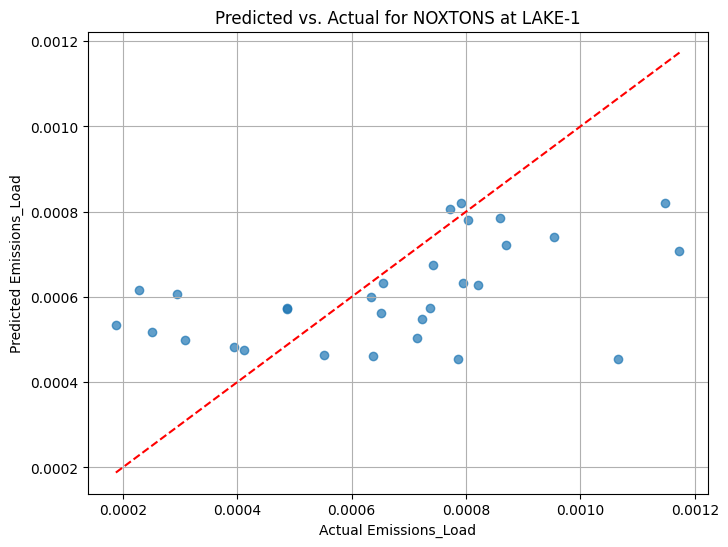

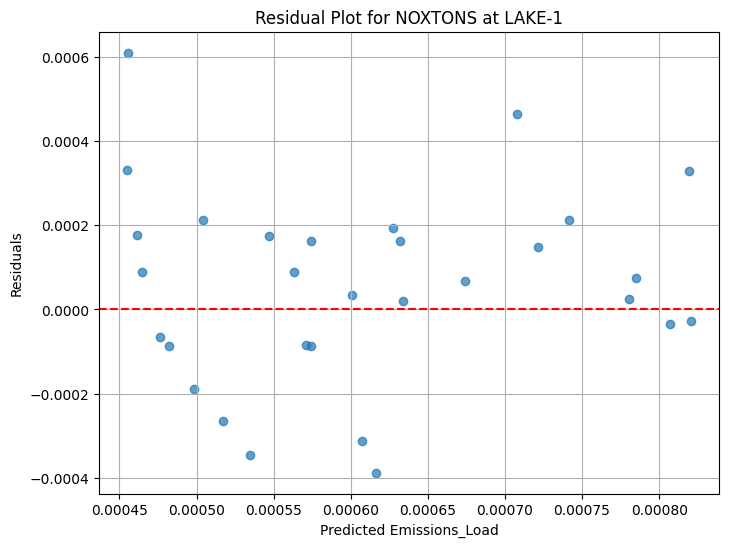

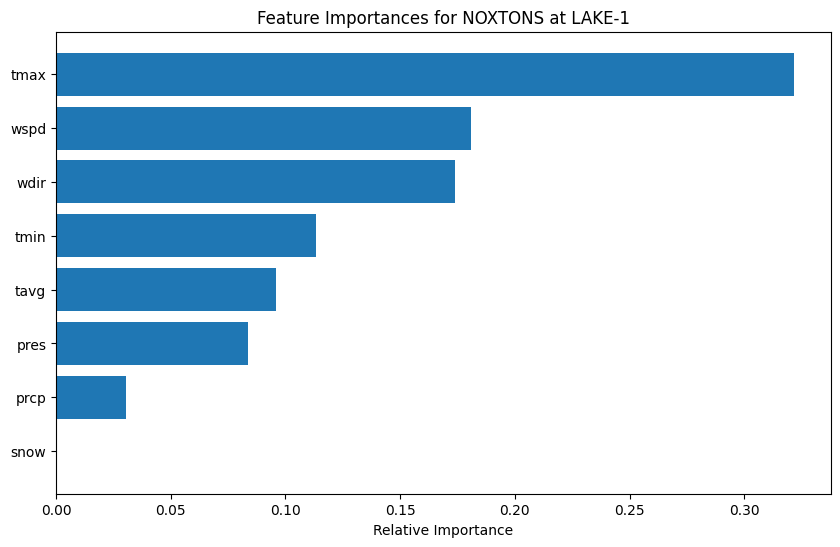

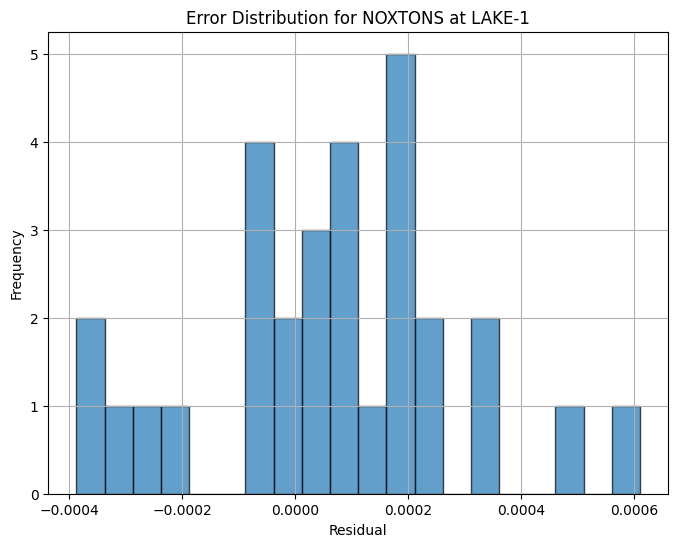

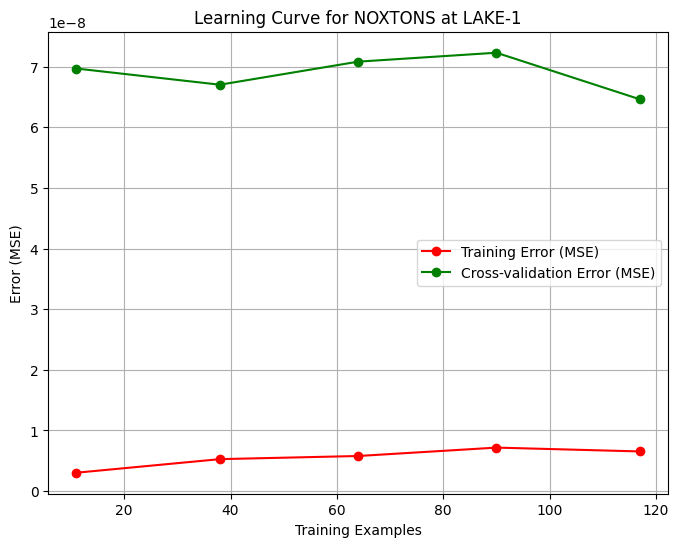

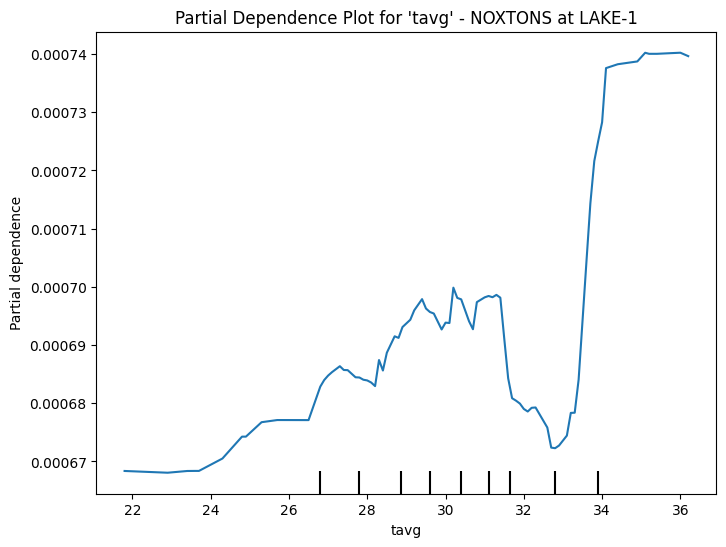

Model for NOXTONS at LAKE-2:
  RMSE: 0.0002
  R²: -0.2474


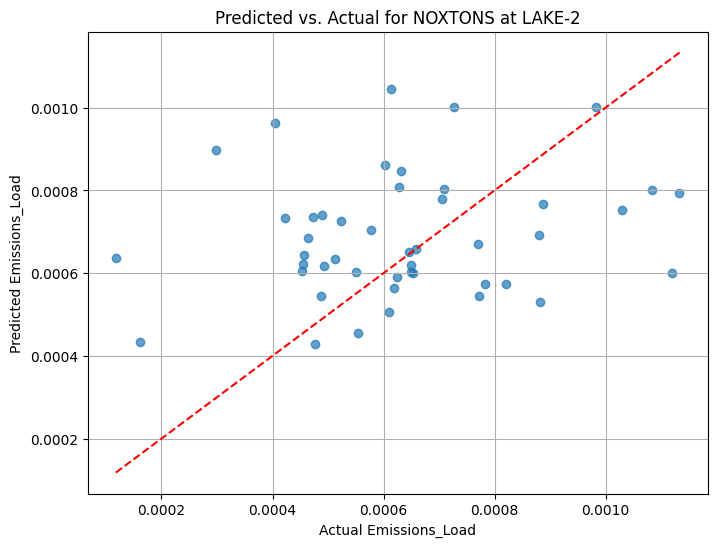

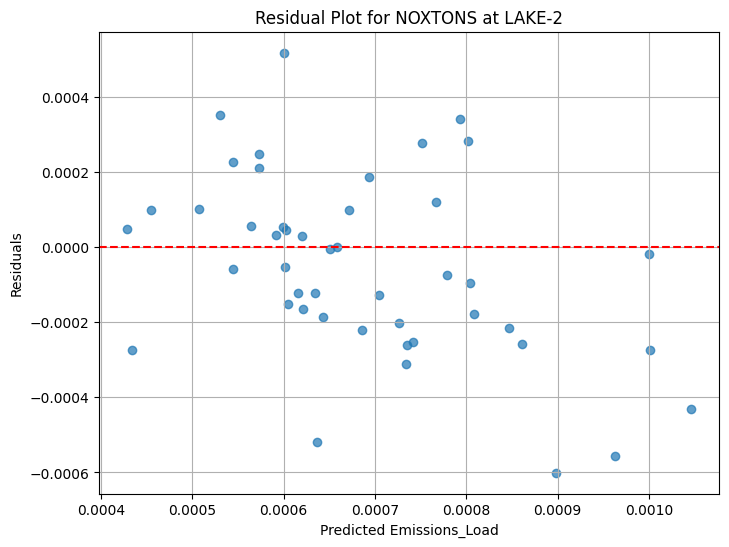

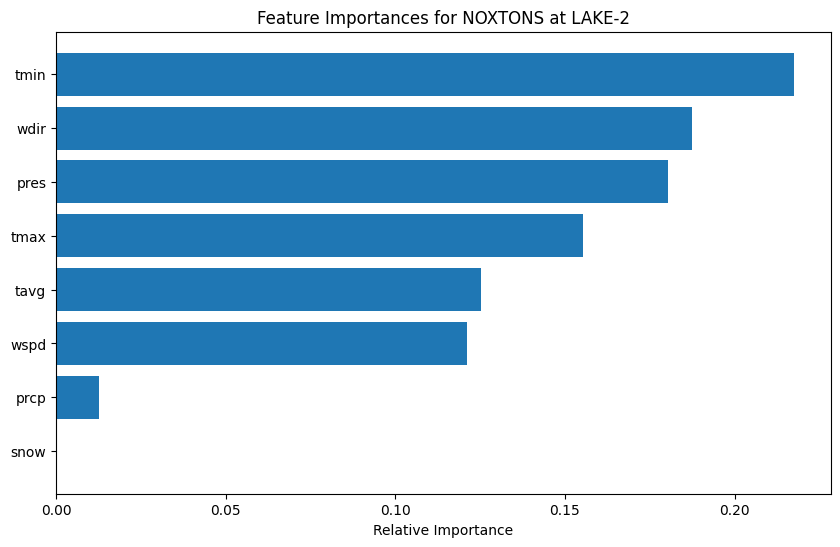

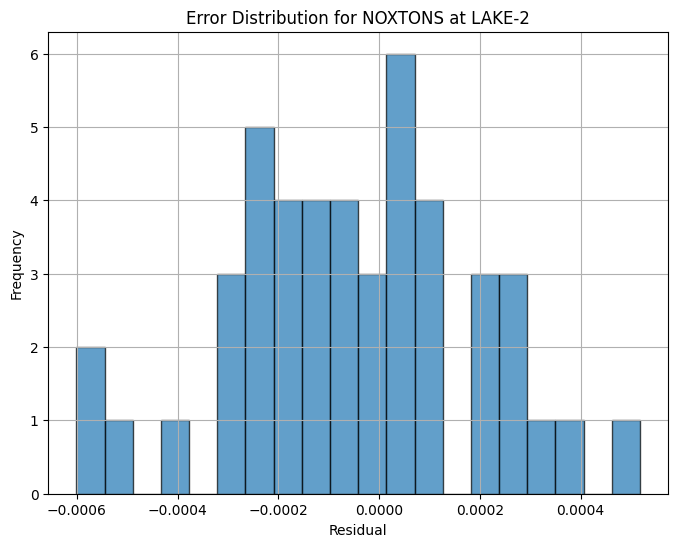

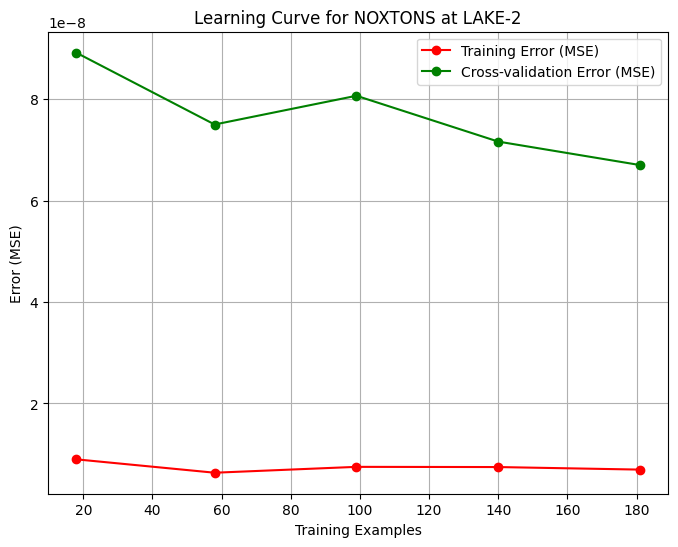

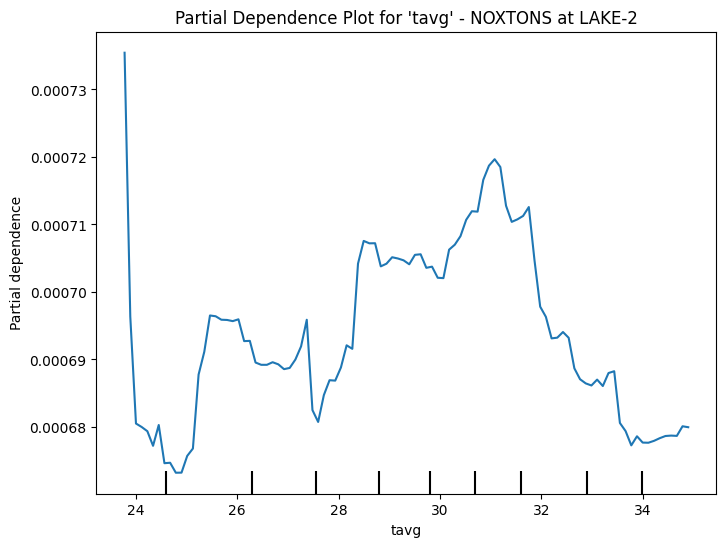

Model for NOXTONS at LAKE-3:
  RMSE: 0.0002
  R²: 0.3383


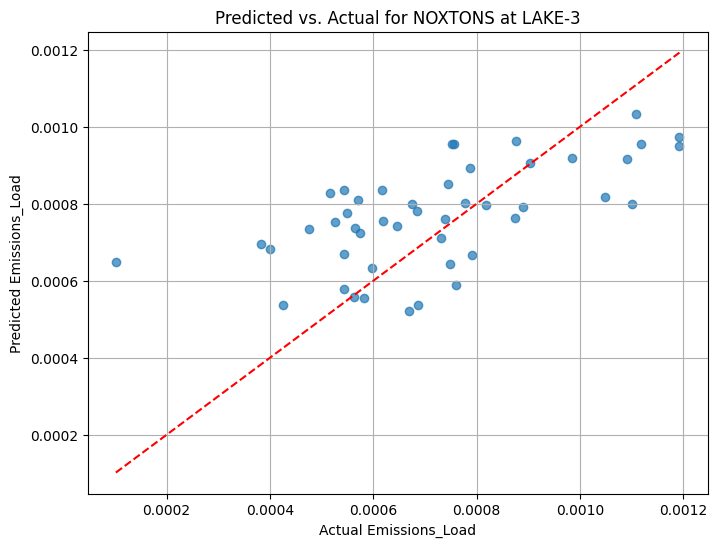

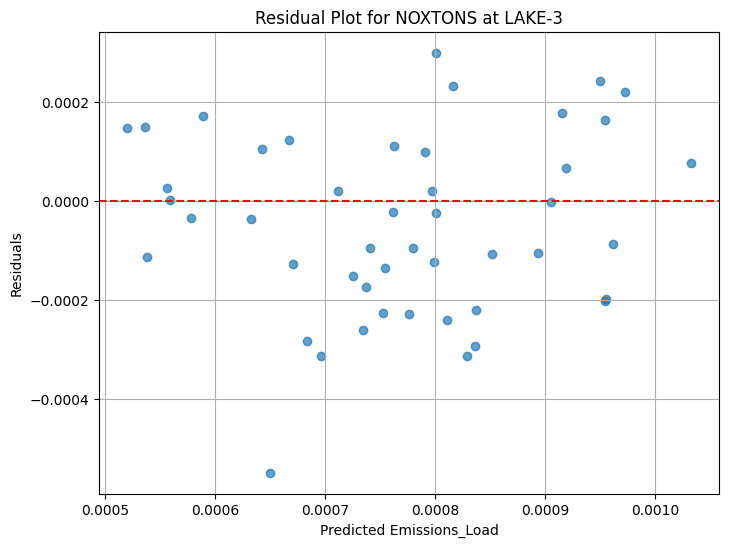

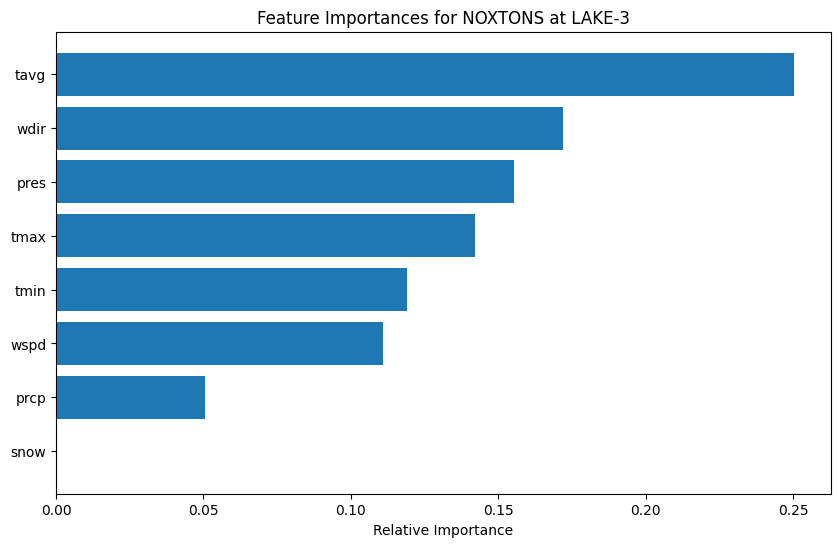

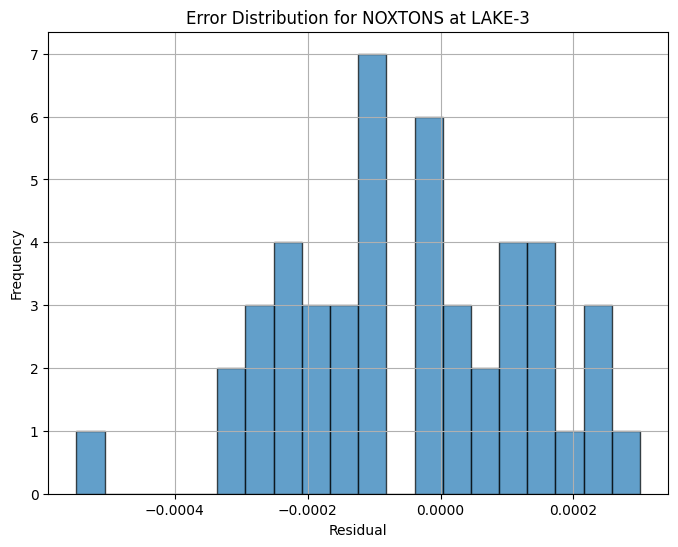

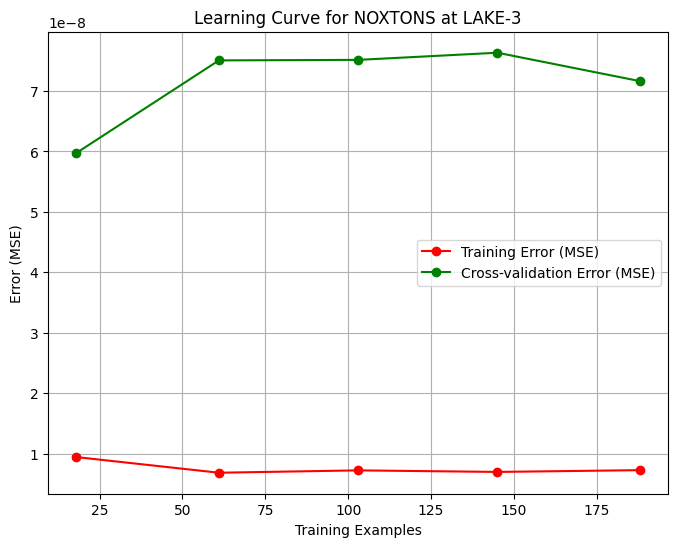

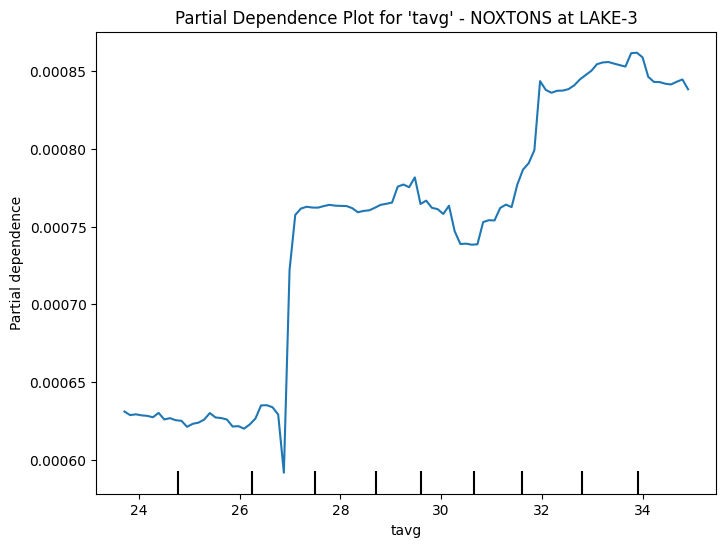

Model for NOXTONS at LAKE-4:
  RMSE: 0.0002
  R²: 0.1243


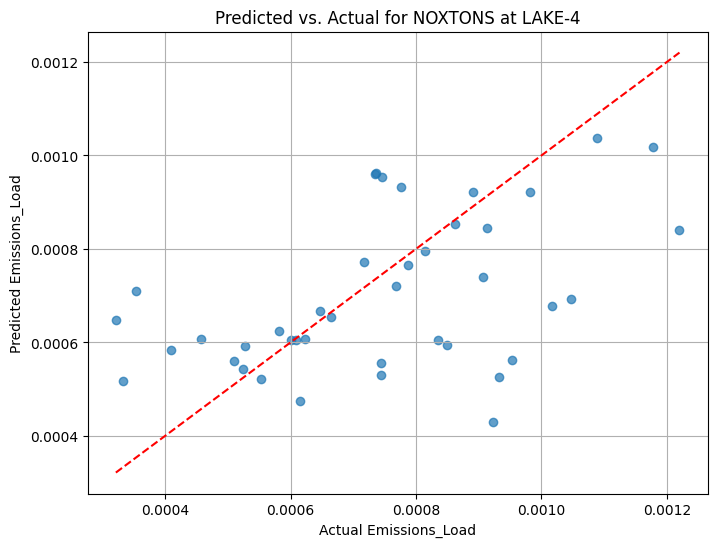

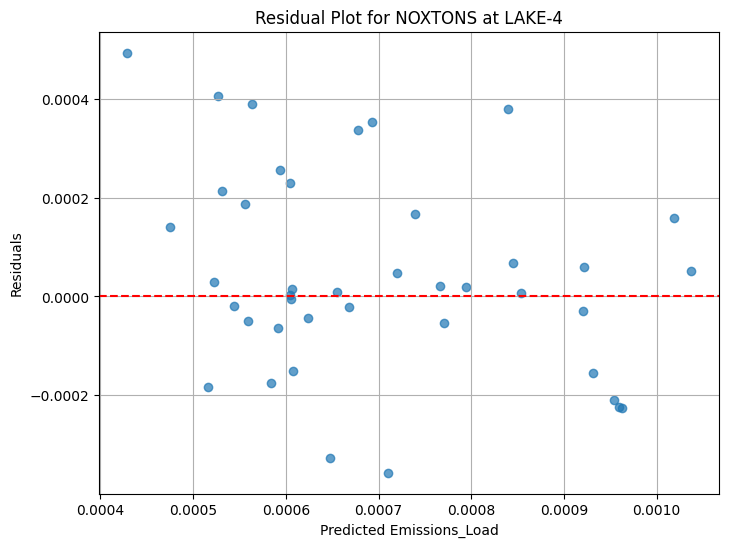

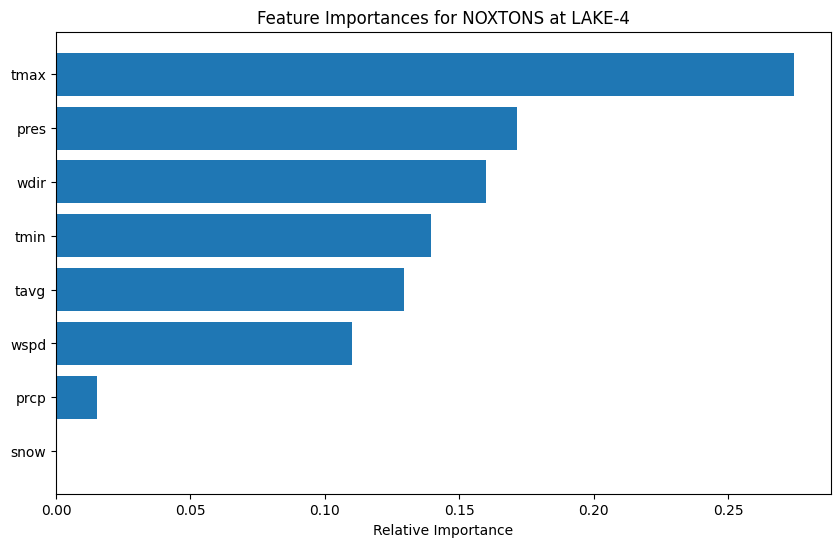

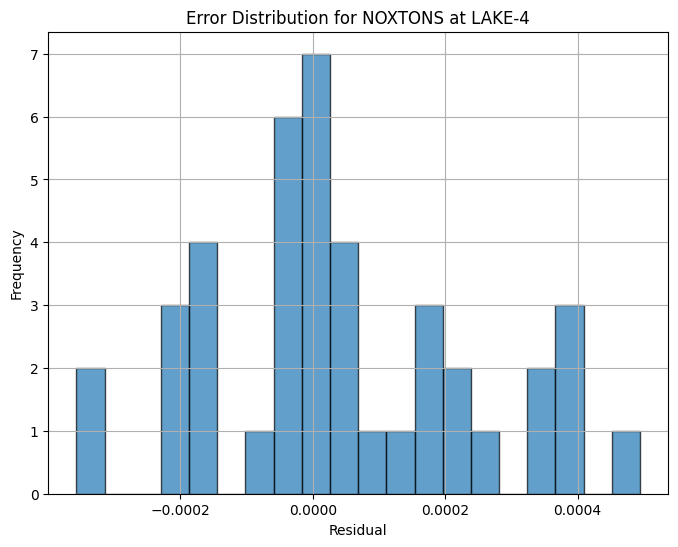

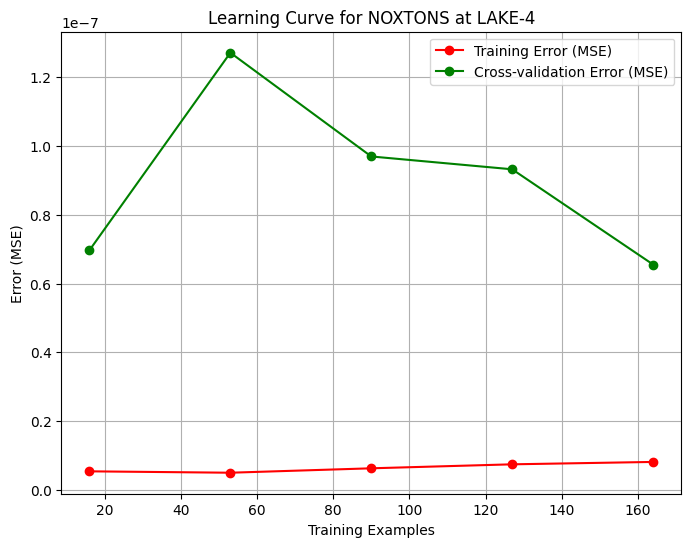

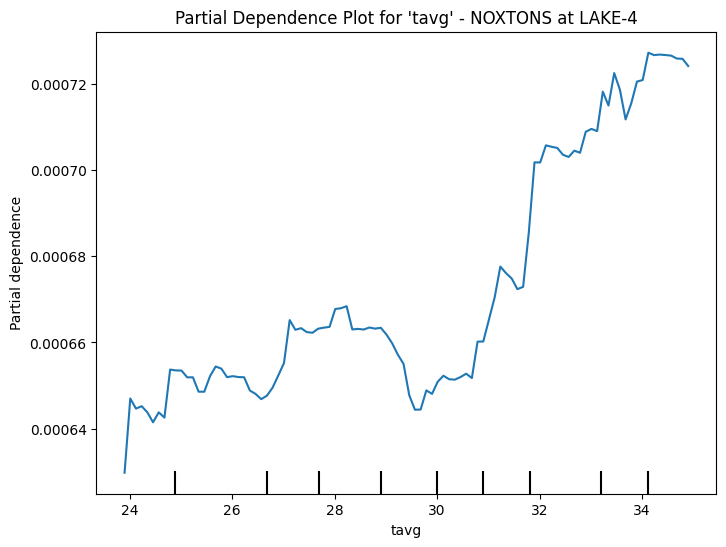

Model for COTONS at LAKE-1:
  RMSE: 0.0001
  R²: 0.1510


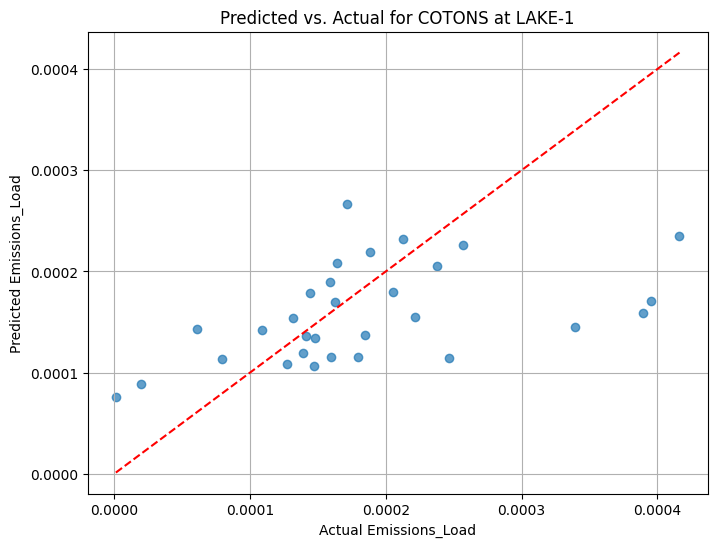

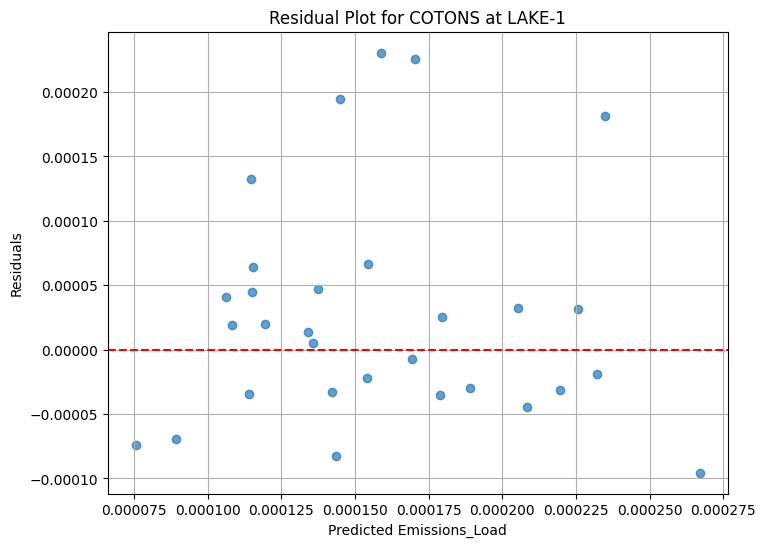

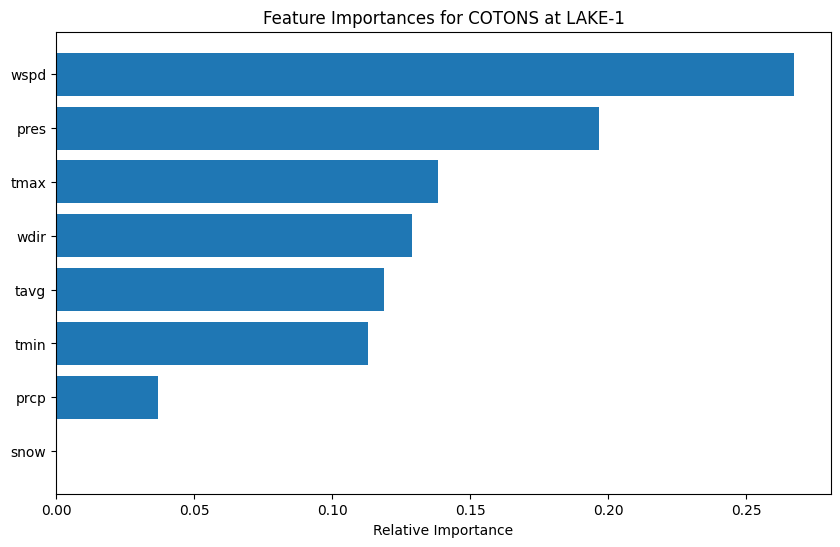

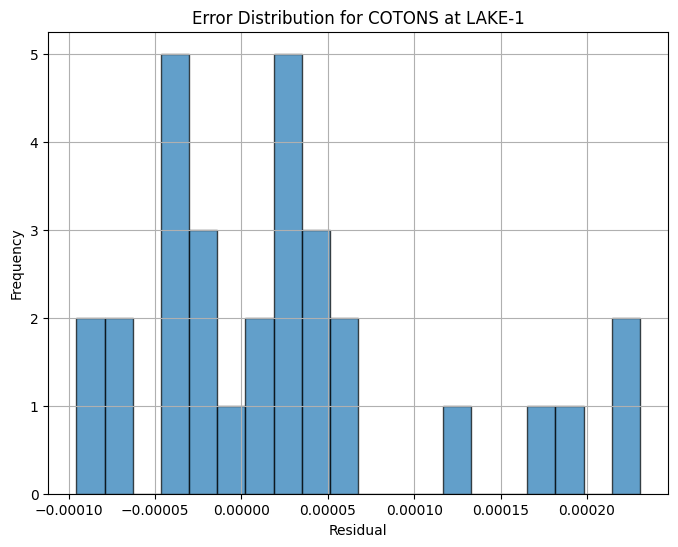

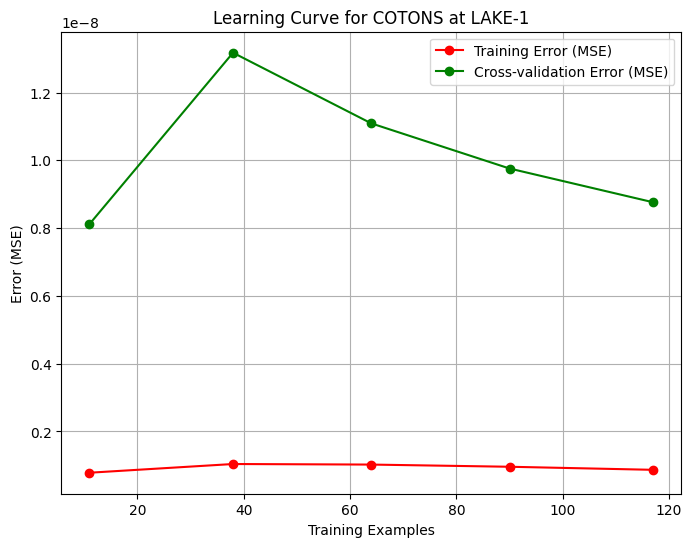

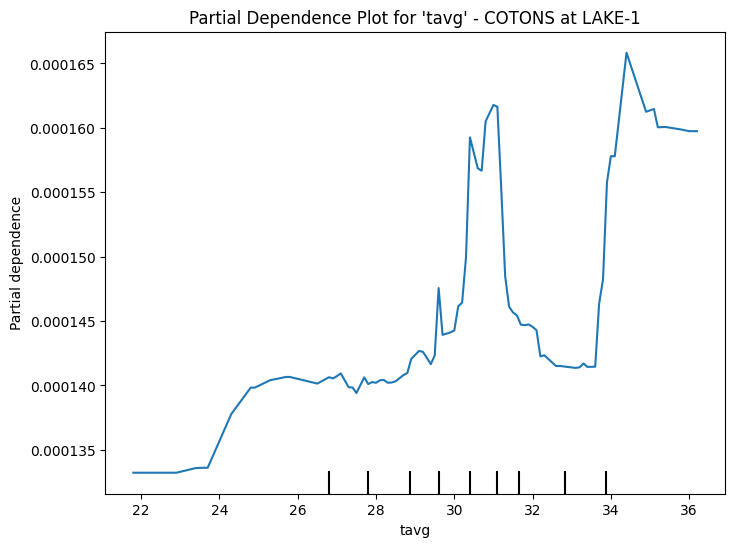

Model for COTONS at LAKE-2:
  RMSE: 0.0001
  R²: -0.3658


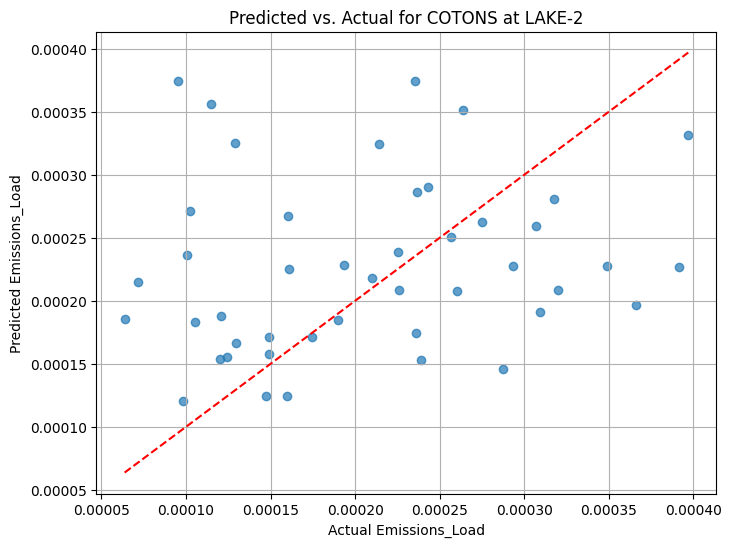

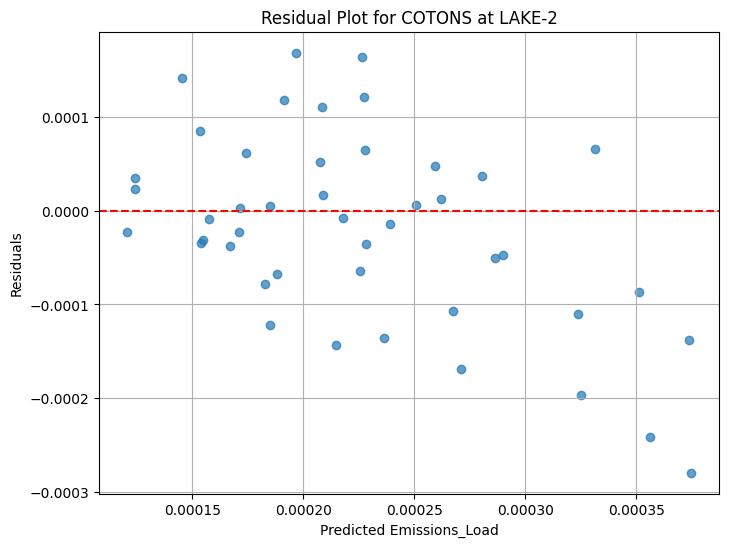

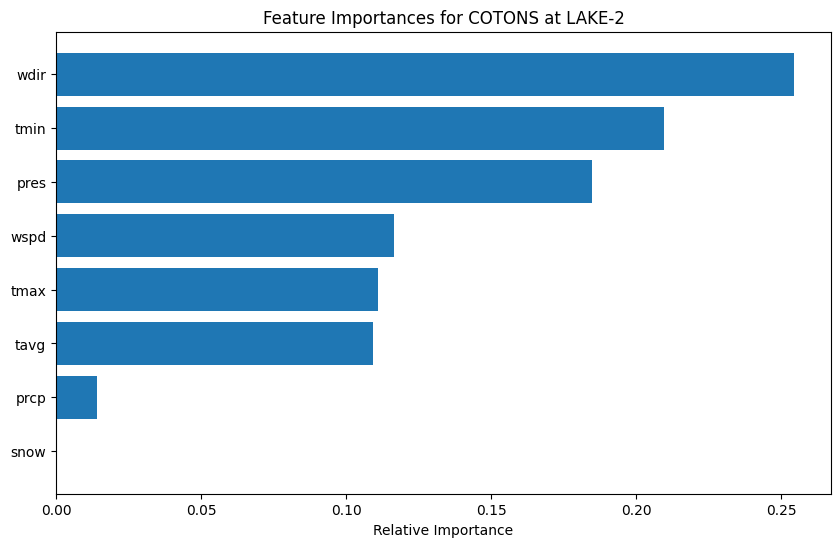

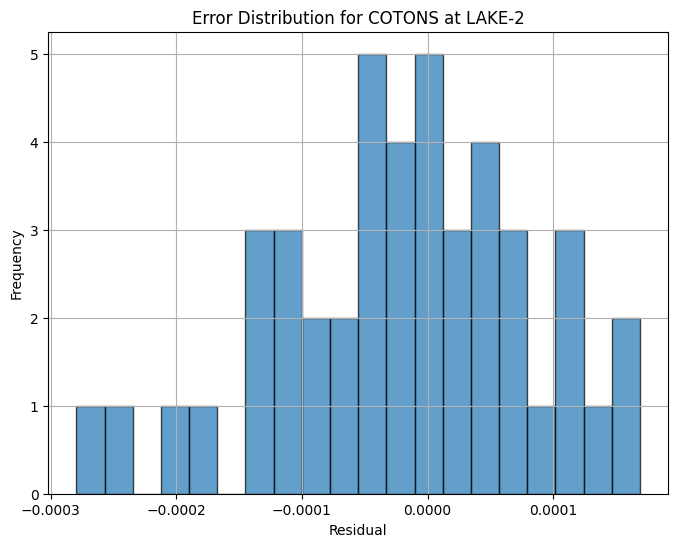

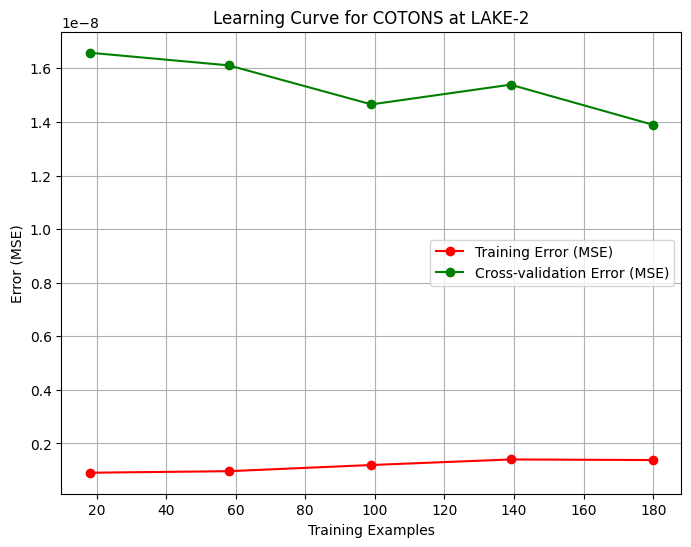

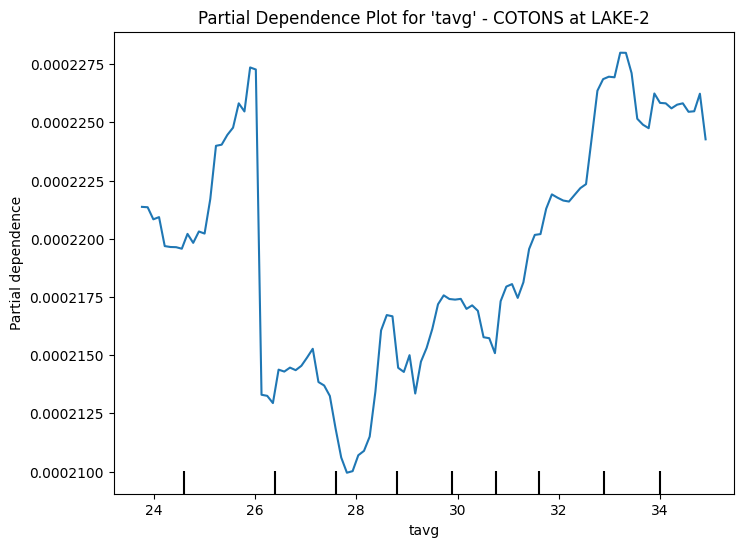

Model for COTONS at LAKE-3:
  RMSE: 0.0001
  R²: 0.2088


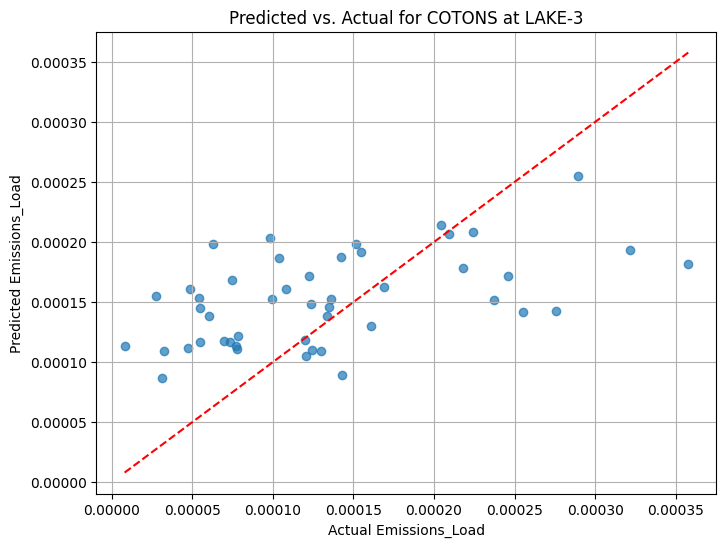

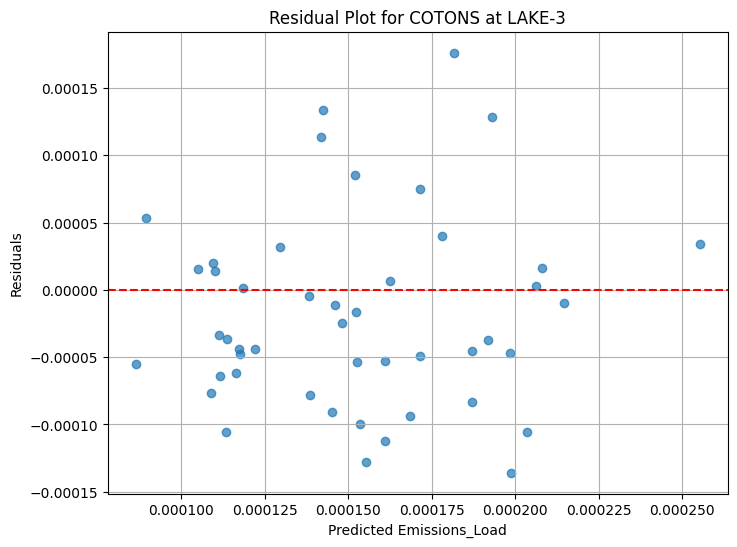

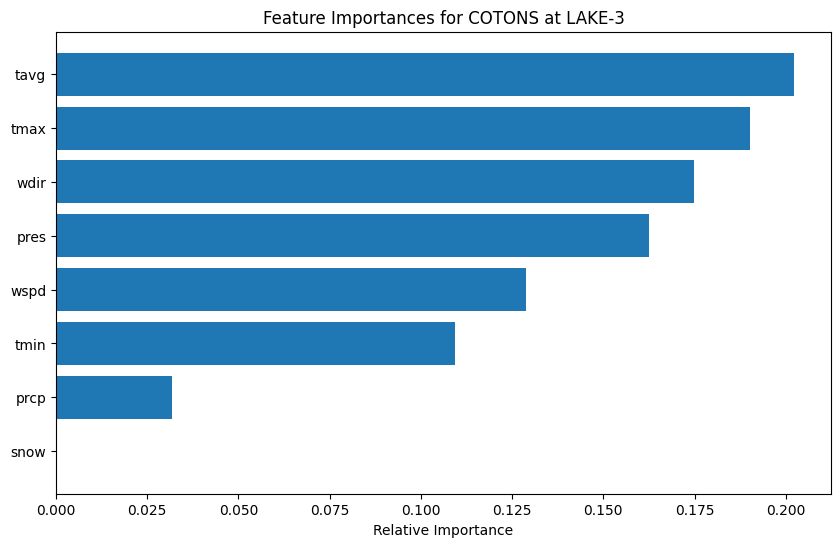

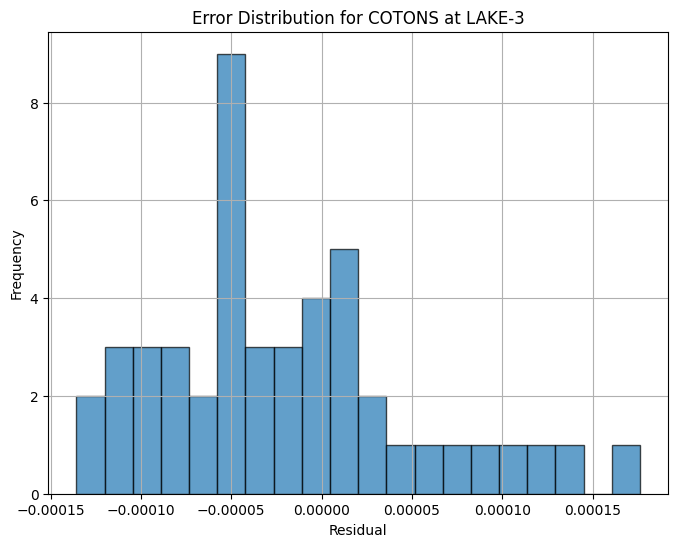

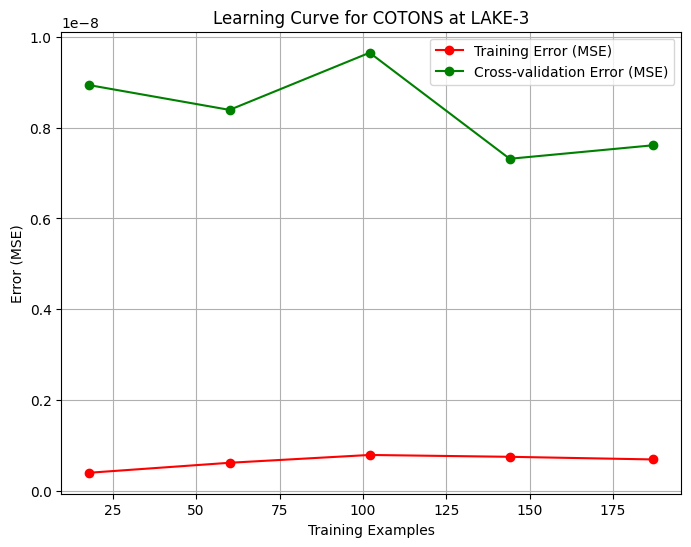

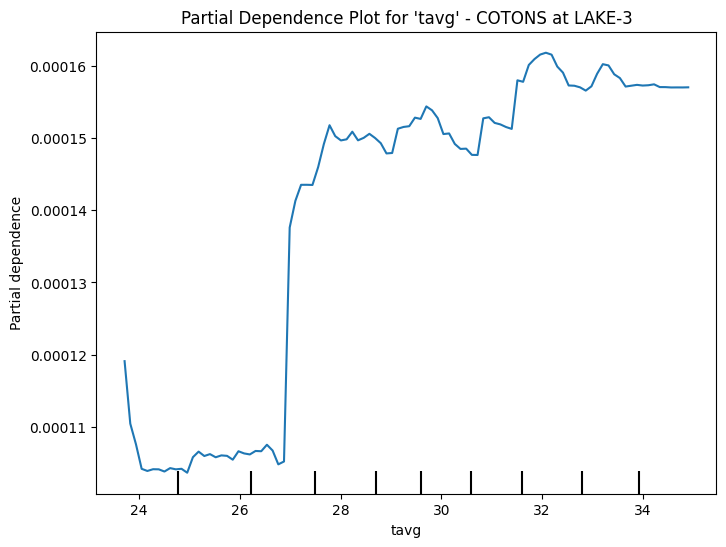

Model for COTONS at LAKE-4:
  RMSE: 0.0001
  R²: 0.1616


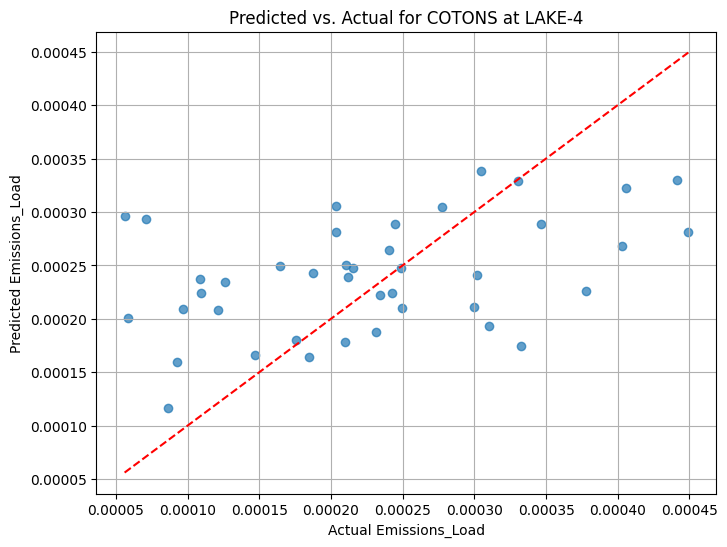

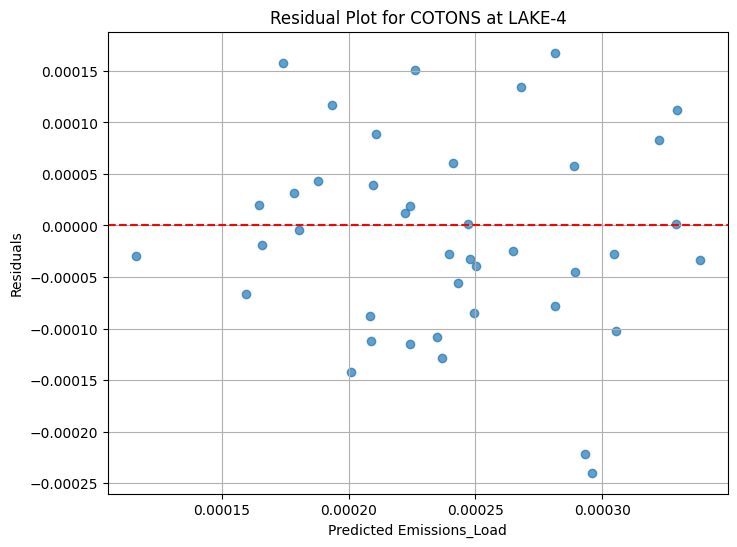

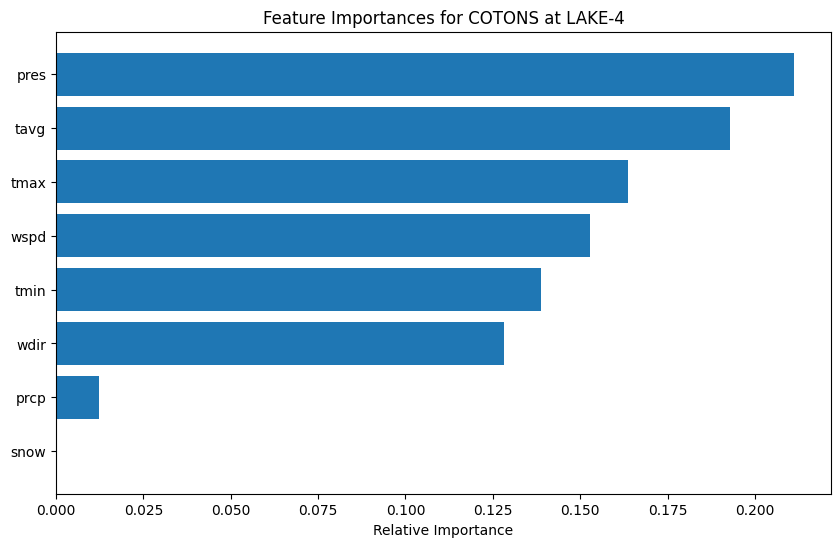

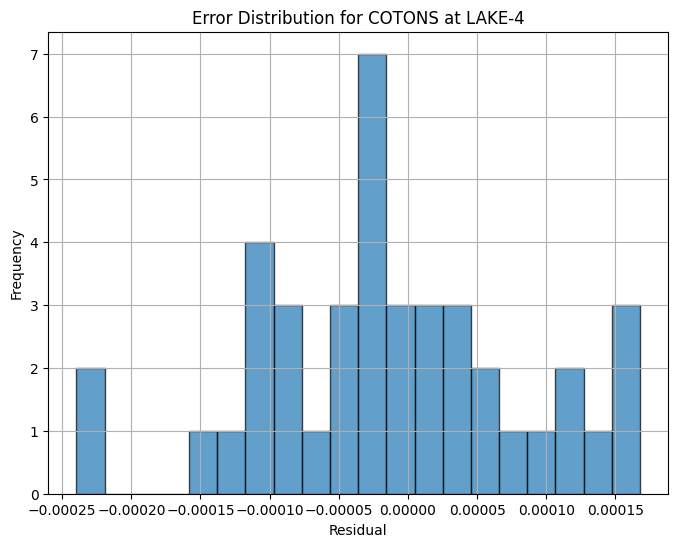

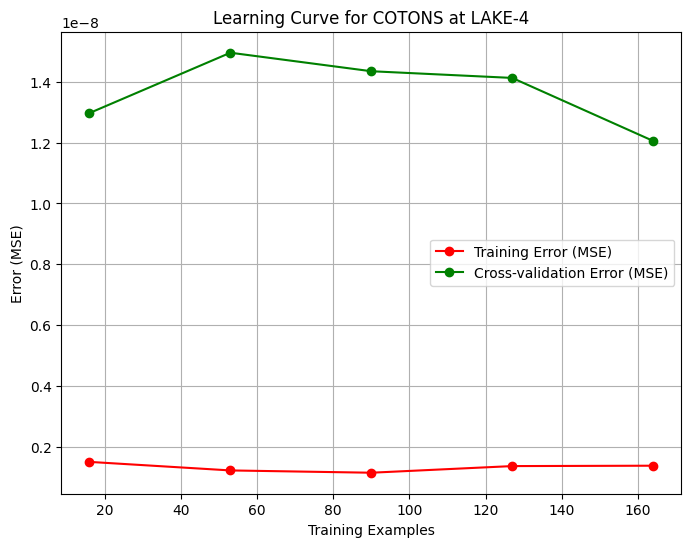

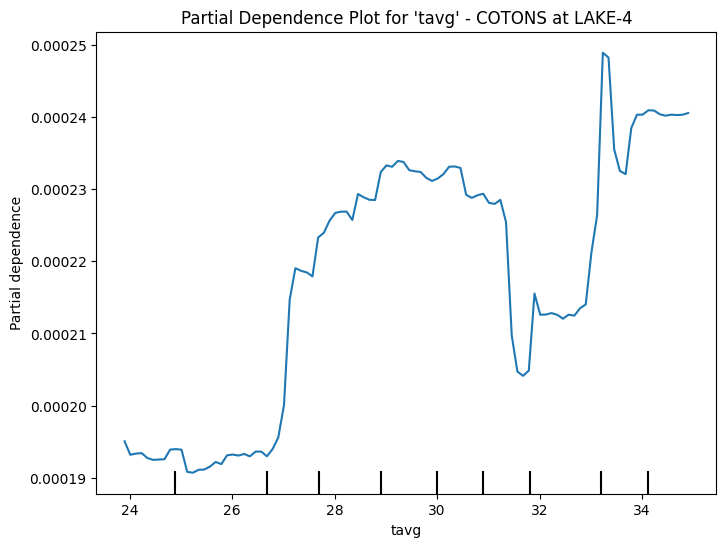


Final Predictions:
SO2TONS at LAKE-1:
  Features: {'tavg': 31.7, 'tmin': 23.3, 'tmax': 38.9, 'prcp': 0.0, 'snow': 0.0, 'wdir': 87.0, 'wspd': 11.2, 'pres': 1011.3}
  Actual Emissions_Load: 0.0000
  Predicted Emissions_Load: 0.0000

SO2TONS at LAKE-2:
  Features: {'tavg': 31.7, 'tmin': 23.3, 'tmax': 38.9, 'prcp': 0.0, 'snow': 0.0, 'wdir': 87.0, 'wspd': 11.2, 'pres': 1011.3}
  Actual Emissions_Load: 0.0000
  Predicted Emissions_Load: 0.0000

SO2TONS at LAKE-3:
  Features: {'tavg': 31.7, 'tmin': 23.3, 'tmax': 38.9, 'prcp': 0.0, 'snow': 0.0, 'wdir': 87.0, 'wspd': 11.2, 'pres': 1011.3}
  Actual Emissions_Load: 0.0000
  Predicted Emissions_Load: 0.0000

SO2TONS at LAKE-4:
  Features: {'tavg': 31.7, 'tmin': 23.3, 'tmax': 38.9, 'prcp': 0.0, 'snow': 0.0, 'wdir': 87.0, 'wspd': 11.2, 'pres': 1011.3}
  Actual Emissions_Load: 0.0000
  Predicted Emissions_Load: 0.0000

NOXTONS at LAKE-1:
  Features: {'tavg': 31.7, 'tmin': 23.3, 'tmax': 38.9, 'prcp': 0.0, 'snow': 0.0, 'wdir': 87.0, 'wspd': 11.2, 'pre

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# URLs for datasets
datasets = {
    "SO2TONS": "https://raw.githubusercontent.com/apownukepcc/ForecastingDailyEmissions/refs/heads/main/SO2TONS_dataset.csv",
    "NOXTONS": "https://raw.githubusercontent.com/apownukepcc/ForecastingDailyEmissions/refs/heads/main/NOXTONS_dataset.csv",
    "COTONS": "https://raw.githubusercontent.com/apownukepcc/ForecastingDailyEmissions/refs/heads/main/COTONS_dataset.csv"
}

# Define the peak season months (May through August)
peak_season_months = [5, 6, 7, 8]

# Define lakes (sources)
sources = ["LAKE-1", "LAKE-2", "LAKE-3", "LAKE-4"]

# Define the specific day for prediction
specific_date = pd.Timestamp("2022-07-15")

# Initialize a dictionary to store models, predictions, and inputs for verification
models = {}
predictions = {}

# Loop through each dataset (SO2TONS, NOXTONS, COTONS)
for parameter, url in datasets.items():
    # Load the dataset
    data = pd.read_csv(url)

    # Convert the 'date' column to datetime
    data['date'] = pd.to_datetime(data['date'])

    # Filter for peak season
    data = data[data['date'].dt.month.isin(peak_season_months)]

    # Separate data by source
    for source in sources:
        source_data = data[data['Source'] == source]

        # Check if the source data has enough rows
        if source_data.empty or len(source_data) < 10:
            print(f"Not enough data for {parameter} at {source}. Skipping...")
            continue

        # Define predictors (e.g., weather features)
        predictors = ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres']
        target = 'Emissions_Load'

        # Drop rows with missing values
        source_data = source_data.dropna(subset=predictors + [target])

        # Split the data into features (X) and target (y)
        X = source_data[predictors]
        y = source_data[target]

        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train a Random Forest Regressor
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        print(f"Model for {parameter} at {source}:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²: {r2:.4f}")

        # Save the model
        models[(parameter, source)] = model

        # ---------------------------
        # Plot 1: Predicted vs. Actual
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.7)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
        plt.xlabel("Actual Emissions_Load")
        plt.ylabel("Predicted Emissions_Load")
        plt.title(f"Predicted vs. Actual for {parameter} at {source}")
        plt.grid(True)
        plt.show()

        # ---------------------------
        # Plot 2: Residual Plot
        residuals = y_test - y_pred
        plt.figure(figsize=(8, 6))
        plt.scatter(y_pred, residuals, alpha=0.7)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Predicted Emissions_Load")
        plt.ylabel("Residuals")
        plt.title(f"Residual Plot for {parameter} at {source}")
        plt.grid(True)
        plt.show()

        # ---------------------------
        # Plot 3: Feature Importance
        importances = model.feature_importances_
        indices = np.argsort(importances)
        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importances for {parameter} at {source}")
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [predictors[i] for i in indices])
        plt.xlabel("Relative Importance")
        plt.show()

        # ---------------------------
        # Plot 4: Error Distribution Histogram
        plt.figure(figsize=(8, 6))
        plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
        plt.xlabel("Residual")
        plt.ylabel("Frequency")
        plt.title(f"Error Distribution for {parameter} at {source}")
        plt.grid(True)
        plt.show()

        # ---------------------------
        # Plot 5: Learning Curve
        # Reinitialize a new RandomForestRegressor for computing the learning curve
        rf = RandomForestRegressor(random_state=42)
        train_sizes, train_scores, test_scores = learning_curve(
            rf, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 5)
        )
        # Compute mean error (convert negative MSE to MSE)
        train_scores_mean = -np.mean(train_scores, axis=1)
        test_scores_mean = -np.mean(test_scores, axis=1)
        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Error (MSE)")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Error (MSE)")
        plt.xlabel("Training Examples")
        plt.ylabel("Error (MSE)")
        plt.title(f"Learning Curve for {parameter} at {source}")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()

        # ---------------------------
        # Plot 6: Partial Dependence Plot for 'tavg'
        fig, ax = plt.subplots(figsize=(8, 6))
        PartialDependenceDisplay.from_estimator(model, X, features=['tavg'], ax=ax)
        plt.title(f"Partial Dependence Plot for 'tavg' - {parameter} at {source}")
        plt.show()

        # ---------------------------
        # Predict for a specific day if available
        day_data = source_data[source_data['date'] == specific_date]
        if not day_data.empty:
            # Extract feature values for the specific day
            specific_features = day_data[predictors].iloc[[0]]  # Retain feature names
            specific_actual = day_data[target].iloc[0]

            # Predict emissions/load for the specific day
            specific_prediction = model.predict(specific_features)[0]

            # Save the prediction and actual value for verification
            predictions[(parameter, source)] = {
                "features": day_data[predictors].iloc[0],
                "actual": specific_actual,
                "predicted": specific_prediction
            }

# Display all predictions at the end
print("\nFinal Predictions:")
for key, value in predictions.items():
    parameter, source = key
    print(f"{parameter} at {source}:")
    print(f"  Features: {value['features'].to_dict()}")
    print(f"  Actual Emissions_Load: {value['actual']:.4f}")
    print(f"  Predicted Emissions_Load: {value['predicted']:.4f}")
    print()
